In [ ]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import yaml

In [ ]:
#!pip install -U sentence-transformers
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113 --user 


In [ ]:
#local
%cd "G:\Meu Drive\Obsidian\Ios3\areas\doutorado\tools"

In [ ]:
!dir

# Carrega dados

In [ ]:
PASTA = 'F1/'

#load mechanics from csv
#GM
dfGM = pd.read_csv(PASTA + 'gm_novos_textos.csv',delimiter='|')
#dfGM["Combined"] = dfGM['Mechanics'].astype(str) +": " + dfGM["Description"]
dfGM['type'] = 'GM'
#dfGM.drop(['Description'], axis=1, inplace=True)
dfGM.reset_index(drop=True)
#dfGM.set_index(["Description", "Mechanics"], inplace = True, append = True, drop = False)

#PC
#Computational Thinking Lines
  #pc_silvajuniorbraz.csv  (linhas do autor: 4.5.2. em diante)
  #pclf.csv                (G. Computational Thinking Lines)
#GGasCT: Bringing Formal Methods to the Computational Thinking:
#pc.csv: linhas (texto longo)
#pc2.csv: termos 
#pc3.csv: pc.csv resumido - parte final
#pclf_linhas_bras a partir da pagina 8 Computational Thinking Lines: A Literature Review to Connect all the Dots
dfPC = pd.read_csv(PASTA + 'pclf_linhas_bras.csv',delimiter='|')
#dfPC["Combined"] = dfPC['Mechanics'].astype(str) +": " + dfPC["Description"]
dfPC['type'] = 'PC'
#dfPC.drop(['Description'], axis=1, inplace=True)
dfPC = dfPC.reset_index(drop=True)
dfPC.sort_values(['Mechanics'], ascending=True, inplace=True)

#LM
dfLM = pd.read_csv(PASTA + 'lm.csv',delimiter='|')
dfLM['type'] = 'LM'
dfLM['Score'] = 0
dfLM = dfLM.rename(columns={'LM': 'Mechanics'})
dfLM = dfLM.rename(columns={'descrição': 'Description'})
dfLM.reset_index(drop=True)

#TB
dfTB = pd.read_csv(PASTA + 'tbsumm.csv',delimiter='|')
dfTB['type'] = 'TB'
dfTB['Score'] = 0
dfTB = dfTB.rename(columns={'TB': 'Mechanics'})
dfTB = dfTB.rename(columns={'descrição': 'Description'})
dfTB.reset_index(drop=True)

#df = pd.concat([dfPC,dfGM], axis=0)
dfGM

# Monta vetores

In [ ]:
textoGM = []
for index, row in dfGM.iterrows():
  textoGM.append(row['Description'])

mecanicasGM = []
for index, row in dfGM.iterrows():
  mecanicasGM.append(row['Mechanics'])

textoLM = []
for index, row in dfLM.iterrows():
  textoLM.append(row['Description'])

textoTB = []
for index, row in dfTB.iterrows():
  textoTB.append(row['Description'])

textoPC = []
for index, row in dfPC.iterrows():
  textoPC.append(row['Description'])

mecanicasPC = []
for index, row in dfPC.iterrows():
  mecanicasPC.append(row['Mechanics'])

perguntasPC = ['Is it related to ',
              'What is ',
             'What is the definition of ',
            'What have similarity to '
           ]


# Calcula

In [67]:
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
#for long passages
MODELSDOT = ['msmarco-distilbert-base-dot-prod-v3','multi-qa-MiniLM-L6-dot-v1','multi-qa-distilbert-dot-v1','multi-qa-mpnet-base-dot-v1','sentence-transformers/multi-qa-mpnet-base-dot-v1']
#for short passages
#            0                  1                           2                           3                   4                   5                   6                       7                        8                                           11
MODELSCOS = ['allenai-specter','msmarco-MiniLM-L12-cos-v5','msmarco-MiniLM-L6-cos-v5','stsb-roberta-large','all-MiniLM-L6-v2','all-mpnet-base-v2','msmarco-MiniLM-L-6-v3','msmarco-roberta-base-v3','all-mpnet-base-v2',
             'gtr-t5-xl','xlm-roberta-large-finetuned-conll03-english','distilbert-base-nli-stsb-mean-tokens','LaBSE','paraphrase-multilingual-MiniLM-L12-v2','cross-encoder/nli-deberta-v3-large','xlm-roberta-large','sentence-transformers/gtr-t5-xxl']
#                 9           10                                          11                                      12       13                                     14                                15                     16
#resultados COS
#modelo   #resultados   #limiar    
#0         156          0.7
#1         12           0.2
#2         23           0.2 
#3         110          0.2 *
#4         37           0.2
#5         61           0.2
#6         27           0.2
#7         4            0.2      
#8         61           0.2
#9         156          0.5

modeloEscolhido = 9
model = SentenceTransformer(MODELSCOS[modeloEscolhido],device="cuda") 

#retira / caso tenha no nome do modelo
MODELSCOS[modeloEscolhido] = MODELSCOS[modeloEscolhido].replace('/','_')

aux =[]
#teste com status (GM)
#emb1 = model.encode("Provides a sense of belonging or meaningful empowerment. Multiple forms of status, such as titles, levels, tiers, rank not just globally but also locally within a community")
for P in textoPC:
  emb1 = model.encode(P,convert_to_tensor=True)
  mPC = dfPC.loc[dfPC['Description'] == P].Mechanics.item()
  for G in textoGM:
    mGM = dfGM.loc[dfGM['Description'] == G].Mechanics.item()
   # gmAux = mGM + ' ' + G #usado para por o nome dentro da descrticao da mecânica!
    emb2 = model.encode(G, convert_to_tensor=True)
    s = util.cos_sim(emb1, emb2)
    #s = util.dot_score(emb1, emb2)

    s = s.item()
    #LIMIAR DE ACEITAÇÃO
    #if (s >=0.2):
    aux.append([mPC,"GM",mGM,G,s,MODELSCOS[modeloEscolhido]])
#print("total:",conta)
df = pd.DataFrame(aux,columns=['PC','type','Mechanics','Mech_desc','score','modelo'])

#dfX = df.copy("deep")


#pega somene o valor mais alto de cada mecanica
#original
#df1 = df.loc[df.groupby(['type','Mechanics'])['score'].idxmax()] 
#df1 = df1.sort_values('score')

#pegando todos
df1 = df.sort_values('score')

dfPrimeiro = df1.copy("deep")
dfPrimeiro = dfPrimeiro.loc[dfPrimeiro['score'] >= 0.51] 
dfPrimeiro.to_excel(PASTA + "xlsx/bertGMLMTB" + MODELSCOS[modeloEscolhido] + ".xlsx")


In [69]:
dfPrimeiro = df1.copy("deep")
dfPrimeiro = dfPrimeiro.loc[dfPrimeiro['score'] >= 0.51] 


linhaAux = 'Abstraction'
dfPrimeiro = dfPrimeiro.loc[dfPrimeiro['PC'] == linhaAux] 
dfPrimeiro

,PC,type,Mechanics,Mech_desc,score,modelo
14,Abstraction,GM,Ownership (GM),Used to create loyalty of the gaming pool. The...,0.515321,gtr-t5-xl
15,Abstraction,GM,Pareto Optimal,A mechanic where the outcome is one in which n...,0.522709,gtr-t5-xl
7,Abstraction,GM,Competition,Competition could mean a player against the ot...,0.524057,gtr-t5-xl
8,Abstraction,GM,Cooperation-Collaboration,"In cooperative games, the mechanics require pl...",0.528111,gtr-t5-xl
10,Abstraction,GM,Game Turns,A segment of the game set aside for certain ac...,0.531446,gtr-t5-xl
6,Abstraction,GM,Communal Discovery,Involves an entire community working together ...,0.533602,gtr-t5-xl
16,Abstraction,GM,Pavlovian Interaction,"Follows the methodology ‘easy to learn, hard t...",0.536609,gtr-t5-xl
25,Abstraction,GM,Tile-Laying,Often drawn by the player for strategic positi...,0.536941,gtr-t5-xl
21,Abstraction,GM,Rewards,Feedback a player would receive for a worthy a...,0.538946,gtr-t5-xl
2,Abstraction,GM,Behavioral Momentum,Used to give confidence and motivate players t...,0.541116,gtr-t5-xl


# Relatório

In [40]:
dfPrimeiro.describe()

,score
count,26.000000
mean,0.565072
std,0.034764
min,0.513511
25%,0.530985
50%,0.565281
75%,0.593584
max,0.625093


In [ ]:
auxRel = []
numeroGM = len(dfPrimeiro.loc[dfPrimeiro['type'] == 'GM'])
#numeroLM = len(dfPrimeiro.loc[dfPrimeiro['type'] == 'LM'])
#numeroTB = len(dfPrimeiro.loc[dfPrimeiro['type'] == 'TB'])

print('GM=',numeroGM,', LM=',numeroLM,', TB=',numeroTB,'. total=',len(dfPrimeiro)) 

In [ ]:
melhor = dfPrimeiro['score'].max()
#print('Melhor=',melhor)

#melhores
df = dfPrimeiro.loc[dfPrimeiro['type'] == 'GM']
df =  df.loc[df['score'].idxmax()]
auxRel.append(['maxGM',df['score'],df['type'],df['Mechanics'],df['PC']])


#piores
df = dfPrimeiro.loc[dfPrimeiro['type'] == 'GM']
df =  df.loc[df['score'].idxmin()]
auxRel.append(['minGM',df['score'],df['type'],df['Mechanics'],df['PC']])


#media
df = dfPrimeiro.loc[dfPrimeiro['type'] == 'GM']
auxRel.append(['medGM', df['score'].mean(),'','',''])
df.describe()

In [ ]:
#cols = [4,5,6]
#dfRelatorio.drop(dfRelatorio.columns[cols],axis=1,inplace=True)

dfRelatorio = pd.DataFrame(auxRel)
dfRelatorio = dfRelatorio.rename({0:'Medida',1:'score',2:'tipo',3:'Mecanica',4:'PC'}, axis=1)  # new method
dfRelatorio

# Graficos

In [70]:
from matplotlib.backends.backend_pdf import PdfPages
df = dfPrimeiro.copy('deep')

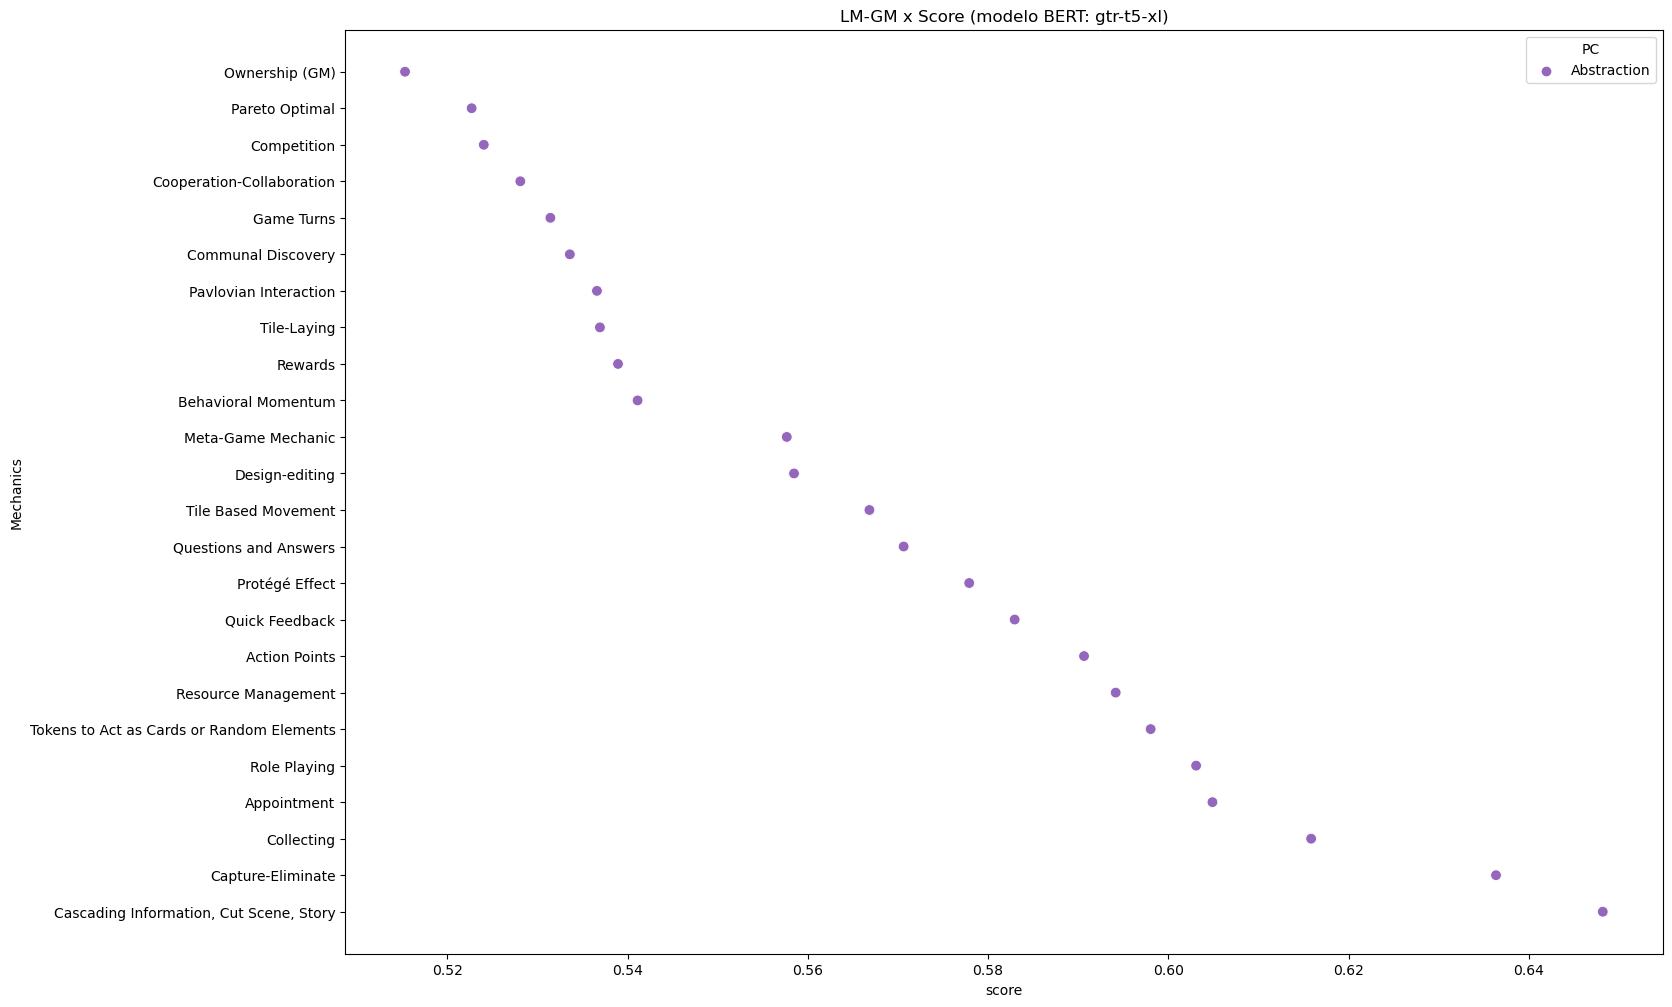

In [71]:
f, ax = plt.subplots(figsize=(17, 12))
ax.set_title("LM-GM x Score (modelo BERT: " + MODELSCOS[modeloEscolhido] + ")")


colors = {
  "Evaluation":"maroon",
  "Decomposition":"green",
  "Abstraction":"#9467bd",
  "Data":"#d62728",
  "Algorithm":"darkorange",
  "Automation":"#1f77b4"
}


# Draw a categorical scatterplot to show each observation
ax = sns.scatterplot(data=df, x="score", y="Mechanics", hue="PC",s=60, palette=colors)
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + linhaAux + '_swarmplot.pdf', bbox_inches='tight')


In [ ]:
f, ax = plt.subplots(figsize=(17, 12))
ax.set_title("LM-GM x Score (modelo BERT: " + MODELSCOS[modeloEscolhido] + ")")



# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=df, x="score", y="Mechanics", hue="PC",size=8, palette=colors)
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_swarmplot.pdf', bbox_inches='tight')

In [ ]:

df = dfPrimeiro.copy('deep')
# Draw a heatmap with the numeric values in each cell
#dados = df.pivot('GM', 'PC', 'score')
f, ax = plt.subplots(figsize=(17, 12))
ax.set_title("LM-GM x PC")
#sns.heatmap(dados, annot=True,  linewidths=.2, ax=ax,cmap="BuPu")

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=df, x="PC", y="Mechanics", hue="PC",size=12, palette=colors)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

plt.xlabel('X label (s)', fontsize=15)
plt.ylabel('Y label (V)', fontsize=15)
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_swarmplot2.pdf', bbox_inches='tight')

# Wordcloud

In [ ]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from matplotlib.pyplot import figure
#Importing Dataset

df = dfPrimeiro.copy('deep')
#Creating the text variable

text2 = " ".join(PC for PC in df.PC)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(width=1600, height=800,collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud
plt.figure(figsize=(20,10))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_wordcloud.pdf', bbox_inches='tight', dpi=300)

# Wordcloud Mech_desc

In [ ]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from matplotlib.pyplot import figure
#Importing Dataset

df = dfPrimeiro.copy('deep')
#Creating the text variable

text2 = " ".join(Mech_desc for Mech_desc in df.Mech_desc)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(width=1600, height=800,collocations = False, background_color = 'white').generate(text2)


# Display the generated Word Cloud
plt.figure(figsize=(20,10))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_wordcloud2.pdf', bbox_inches='tight', dpi=300)

# heatmap 

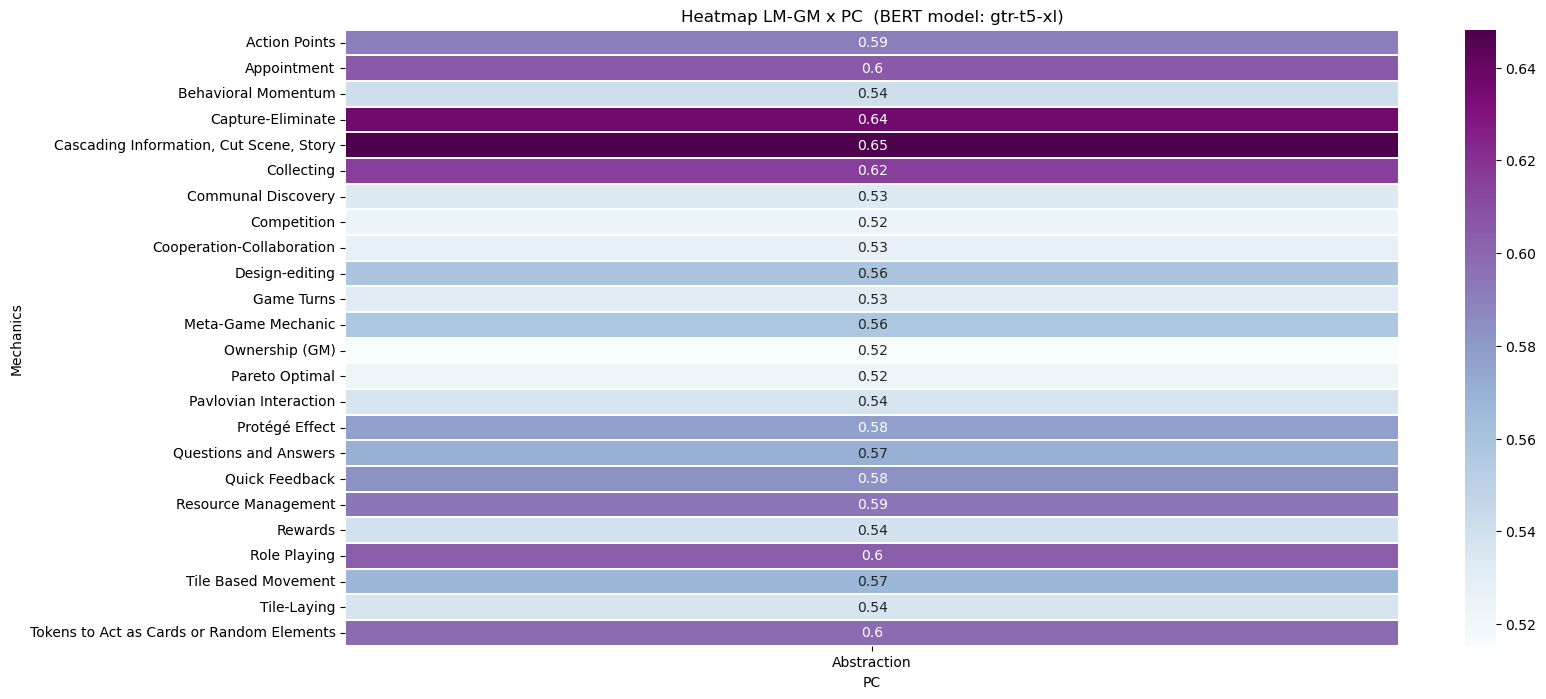

In [73]:
# Draw a heatmap with the numeric values in each cell
df = dfPrimeiro.copy('deep')
dados = df.pivot('Mechanics', 'PC', 'score')
f, ax = plt.subplots(figsize=(17, 8))
ax.set_title("Heatmap LM-GM x PC  (BERT model: " + MODELSCOS[modeloEscolhido] + ")")
sns.heatmap(dados, annot=True, linewidths=.1, ax=ax,cmap="BuPu")
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_' + linhaAux + '_heatmap.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# Draw a heatmap with the numeric values in each cell
#dados = df.pivot('GM', 'PC', 'score')
f, ax = plt.subplots(figsize=(17, 12))
ax.set_title(MODELSCOS[modeloEscolhido])
#sns.heatmap(dados, annot=True,  linewidths=.2, ax=ax,cmap="BuPu")

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=df, x="score", y="type", hue="PC",size=11)
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_swarm3.pdf', bbox_inches='tight', dpi=300)

---

---